# Imports

In [1]:
import MySQLdb as sql
import h5py
from earth.utils import generateFilePathStr
import numpy as np
import random
import pandas as pd
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

import plotly.offline as plotly
import plotly.graph_objs as go
plotly.init_notebook_mode(connected=True)

/opt/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Generate Datasets

In [2]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']

In [6]:
db = sql.connect(db='earthdat', host='104.199.118.158', user='root')
cur = db.cursor()
cur.execute('SELECT lid, x_coord, y_coord, label FROM cloud_detection_kmeans2 WHERE label!= 2 ORDER BY RAND() LIMIT 700000;')
results = cur.fetchall()
db.close()

In [9]:
grid_size = 2
dataset = np.empty((700000, grid_size ** 2 * 8))
labels = np.full((700000,), 2, dtype='uint8')
lids = []
with h5py.File(generateFilePathStr(kind='database'), 'r') as h:
    i = 0
    for lid, x, y, status in results:
        subimage = np.zeros((len(bands), grid_size**2))
        for j, b in enumerate(bands):
            subimage[j] = h[lid][b][
                x - int(grid_size / 2) : x + int(grid_size / 2),
                y - int(grid_size / 2) : y + int(grid_size / 2)
            ].flatten()
        dataset[i] = subimage.flatten()
        labels[i] = status
        lids.append(lid)
        i += 1

dataset = dataset[labels!=2]
lids = pd.Series(lids)[labels != 2]
labels = labels[labels!=2].astype('int')

# Decision Tree

In [301]:
trainset = dataset[:699000]
trainlabels = labels[:699000]
testset = dataset[699000:]
testlabels = labels[699000:]

In [303]:
dtree = RandomForestClassifier(256, max_depth=64)
dtree.fit(trainset, trainlabels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=64, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [304]:
# Train Error
print(np.sum(abs(dtree.predict(trainset) - trainlabels)))

# Test error
print(np.sum(abs(dtree.predict(testset) - testlabels)))

54
77


In [306]:
def get_mini_scene(sceneid, x, y, size, h5F):
    shift_size = int(size / 2)
    vis_image = np.asarray(Image.open(generateFilePathStr(sceneid, 'preproc', 'visible')))[
        x - shift_size : x + shift_size,
        y - shift_size : y + shift_size
    ]
    
    full_image = np.empty((len(bands), size, size))
    for i, b in enumerate(bands):
        full_image[i] = h5F[sceneid][b][
            x - shift_size : x + shift_size,
            y - shift_size : y + shift_size
        ]
    
    return vis_image, full_image


def get_samples_from_scene(image, n):
    grid_size = 2
    x_list = []
    y_list = []
    dataset = np.empty((n, len(bands) * grid_size ** 2))

    j = 0
    for _ in range(n):
        dim = image.shape
        subimage = np.empty((len(bands), grid_size, grid_size))
        x = random.randint(int(grid_size / 2), dim[1] - int(grid_size / 2) - 1)
        y = random.randint(int(grid_size / 2), dim[2] - int(grid_size / 2) - 1)

        for i in range(len(bands)):
            subimage[i] = image[i][
                x - int(grid_size / 2) : x + int(grid_size / 2),
                y - int(grid_size / 2) : y + int(grid_size / 2)
            ]

        dataset[j] = subimage.flatten()
        x_list.append(x)
        y_list.append(y)
        j += 1
        
    reference_df = pd.DataFrame({
        'x': x_list,
        'y': y_list
    })
    
    return dataset, reference_df

In [353]:
with h5py.File(generateFilePathStr(kind = 'database'), 'r') as h5F:
    vis_im, full_im = get_mini_scene('LC80010782016358LGN00', 1600, 1800, 1200, h5F)
map_image = np.zeros((1200, 1200), dtype='uint8')
vis_im_masked = vis_im.copy()

In [354]:
for run in range(10):
    sampleset, reference_df = get_samples_from_scene(full_im, 20000)
    sample_pred = dtree.predict(sampleset)

    for i in range(sample_pred.shape[0]):
        x = reference_df['x'][i]
        y = reference_df['y'][i]
        if sample_pred[i] == 0:
            vis_im_masked[x, y, 0] = 255
            map_image[x, y] = 255

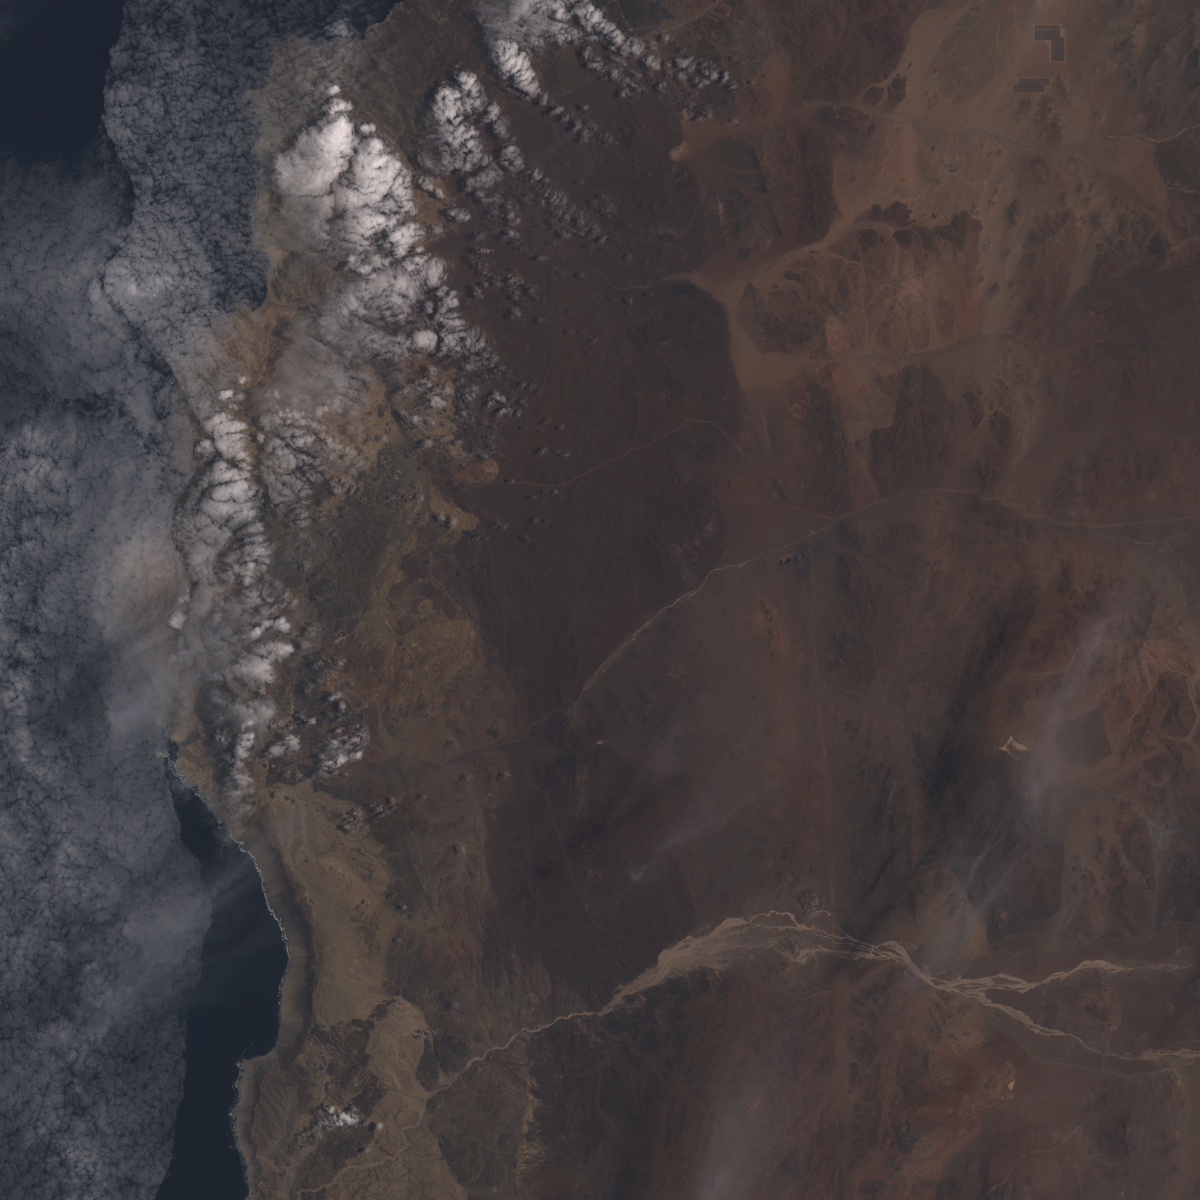

In [355]:
Image.fromarray(vis_im)

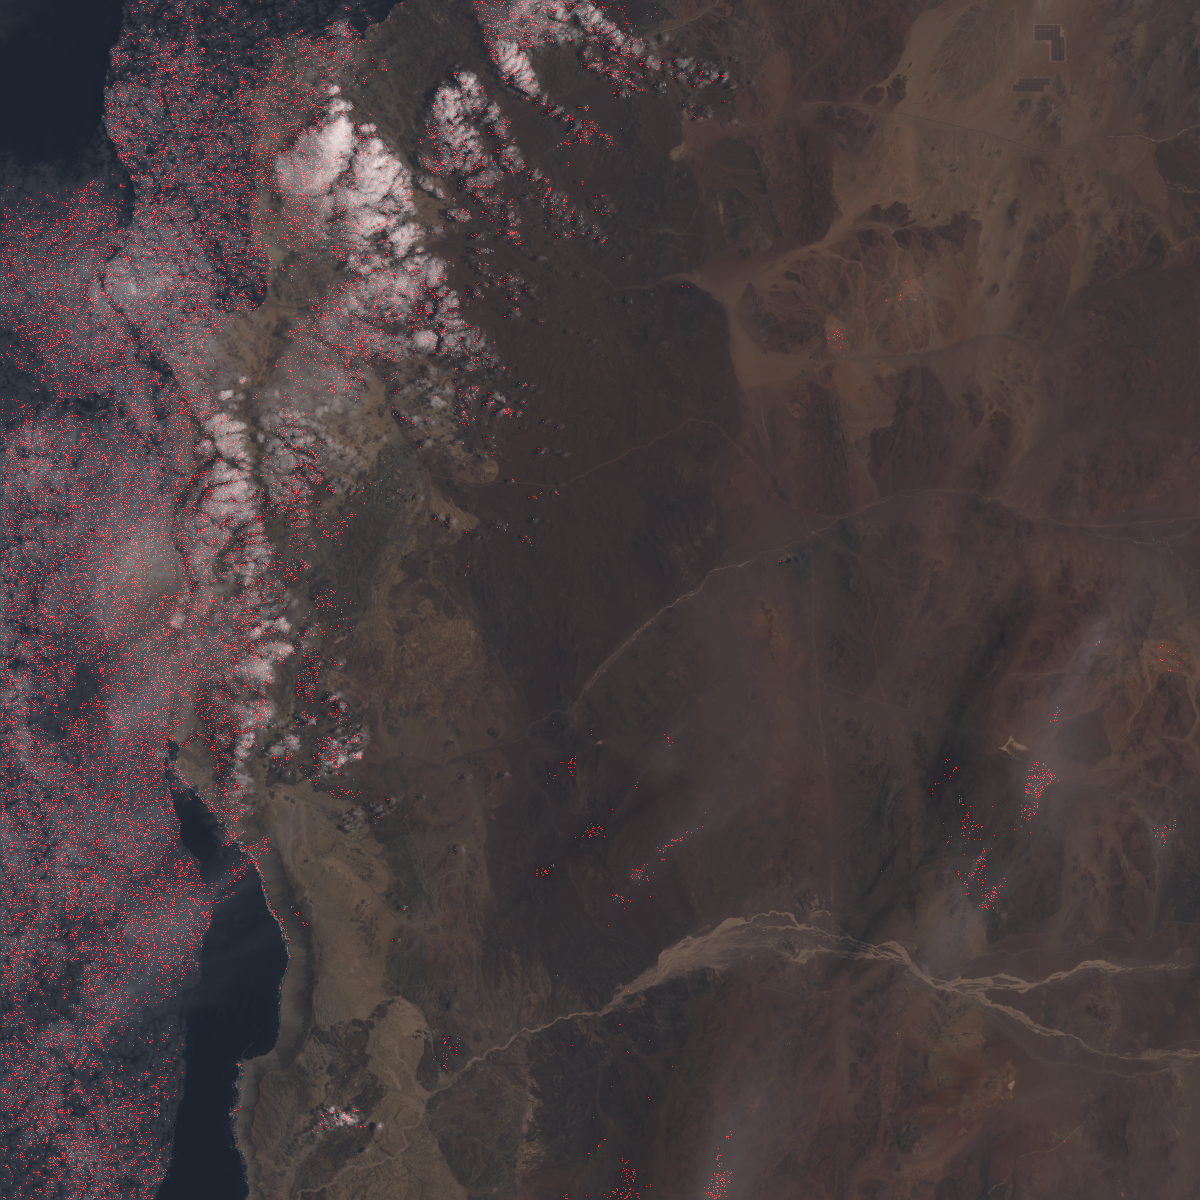

In [356]:
Image.fromarray(vis_im_masked)